In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error
from math import sqrt
from tqdm import tqdm

plt.rcParams["figure.figsize"] = (12, 6)


 1. Load, Convert Dates & Set Index

In [2]:
df = pd.read_csv("C:/Users/hp/Downloads/countdata.csv")

df['ds'] = pd.to_datetime(df['Date'], errors='coerce')
df['y'] = df['Total_Shipments']

df = df[['ds', 'y']].dropna()
df = df.sort_values('ds')


In [3]:
print("Date range:", df['ds'].min(), "→", df['ds'].max())
print("Missing days:", (df['ds'].diff().dt.days > 1).sum())


Date range: 2022-03-14 00:00:00 → 2024-09-02 00:00:00
Missing days: 155


In [4]:
full_dates = pd.date_range(
    start=df['ds'].min(),
    end=df['ds'].max(),
    freq='D'
)

df_seq = (
    df.set_index('ds')
      .reindex(full_dates)
      .rename_axis('ds')
      .reset_index()
)

df_seq['y'] = df_seq['y'].interpolate(method='linear')


In [5]:
last_actual_date = df_seq['ds'].max()
print(last_actual_date)

2024-09-02 00:00:00


In [6]:
df_seq['y'] = np.log1p(df_seq['y'])


In [7]:
model = Prophet(
    growth='linear',
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False,
    seasonality_mode='multiplicative',
    changepoint_prior_scale=0.05
)

model.fit(df_seq)


14:43:54 - cmdstanpy - INFO - Chain [1] start processing
14:43:54 - cmdstanpy - INFO - Chain [1] done processing


In [8]:
forecast_horizon = 60  # change to 30 if needed

future = model.make_future_dataframe(
    periods=forecast_horizon,
    freq='D'
)


In [9]:
forecast = model.predict(future)

# Reverse log transform
forecast['yhat'] = np.expm1(forecast['yhat'])
forecast['yhat_lower'] = np.expm1(forecast['yhat_lower'])
forecast['yhat_upper'] = np.expm1(forecast['yhat_upper'])


In [10]:
last_actual_date = df_seq['ds'].max()

forecast_history = forecast[forecast['ds'] <= last_actual_date]
forecast_future = forecast[forecast['ds'] > last_actual_date]

print("Future rows:", len(forecast_future))  # MUST be > 0


Future rows: 60


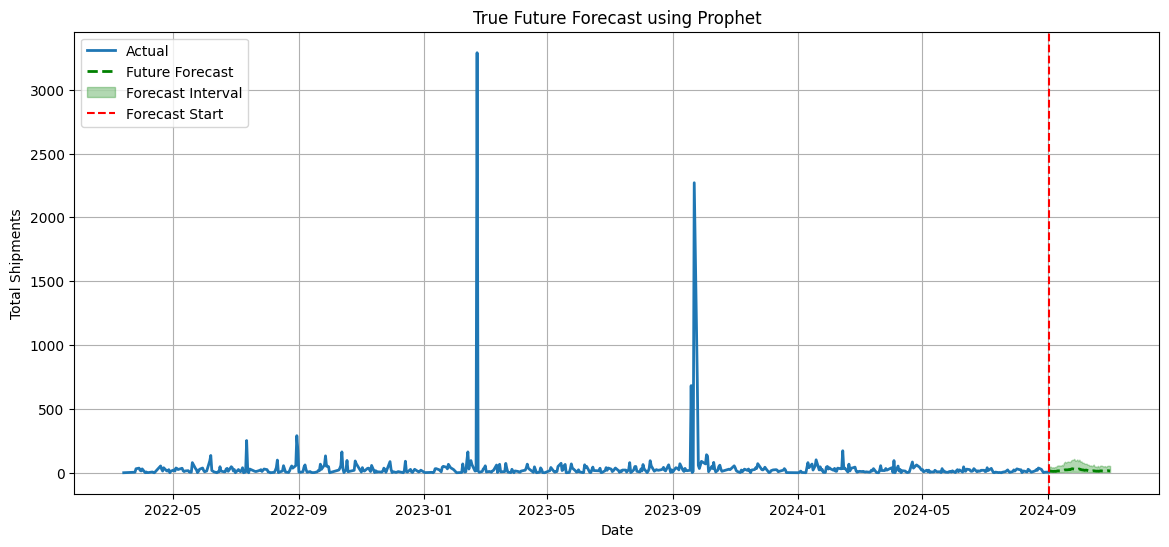

In [11]:
actual_df = df_seq.copy()
actual_df['actual'] = np.expm1(actual_df['y'])

plt.figure(figsize=(14, 6))

# Actual values
plt.plot(
    actual_df['ds'],
    actual_df['actual'],
    label='Actual',
    linewidth=2
)

# Future forecast ONLY
plt.plot(
    forecast_future['ds'],
    forecast_future['yhat'],
    label='Future Forecast',
    linestyle='--',
    linewidth=2,
    color='green'
)

# Confidence interval
plt.fill_between(
    forecast_future['ds'],
    forecast_future['yhat_lower'],
    forecast_future['yhat_upper'],
    color='green',
    alpha=0.3,
    label='Forecast Interval'
)

# Forecast start line
plt.axvline(
    x=last_actual_date,
    color='red',
    linestyle='--',
    label='Forecast Start'
)

plt.title("True Future Forecast using Prophet")
plt.xlabel("Date")
plt.ylabel("Total Shipments")
plt.legend()
plt.grid(True)
plt.show()


In [12]:
# Convert actuals back from log
actual_df = df_seq.copy()
actual_df['actual'] = np.expm1(actual_df['y'])

# Align actuals with forecast horizon
actual_future = actual_df[
    actual_df['ds'].isin(forecast_future['ds'])
]


In [13]:
print(actual_future.columns)
print(actual_future.index.name)


Index(['ds', 'y', 'actual'], dtype='object')
None


In [14]:
# Set index ONLY if ds exists as a column
if 'ds' in actual_future.columns:
    actual_future = actual_future.set_index('ds')

if 'ds' in forecast_future.columns:
    forecast_future = forecast_future.set_index('ds')

actual_future = actual_future.sort_index()
forecast_future = forecast_future.sort_index()


In [15]:
print("Actual rows:", len(actual_future))
print("Forecast rows:", len(forecast_future))


Actual rows: 0
Forecast rows: 60


In [16]:
horizon = 60  # same as forecast horizon

train_df = df_seq.iloc[:-horizon]
valid_df = df_seq.iloc[-horizon:]


In [17]:
model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False,
    seasonality_mode='multiplicative'
)

model.fit(train_df)


14:43:55 - cmdstanpy - INFO - Chain [1] start processing
14:43:55 - cmdstanpy - INFO - Chain [1] done processing


In [18]:
future_valid = model.make_future_dataframe(
    periods=horizon,
    freq='D'
)

forecast_valid = model.predict(future_valid)
forecast_valid = forecast_valid.tail(horizon)

# Reverse log transform
forecast_valid['yhat'] = np.expm1(forecast_valid['yhat'])


In [19]:
actual_valid = valid_df.copy()
actual_valid['actual'] = np.expm1(actual_valid['y'])


In [32]:
from sklearn.metrics import mean_squared_error
from math import sqrt
import numpy as np

mse = mean_squared_error(
    actual_valid['actual'].values,
    forecast_valid['yhat'].values
)

rmse = sqrt(mse)

def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mask = y_true != 0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

mape_value = mape(
    actual_valid['actual'].values,
    forecast_valid['yhat'].values
)

print(f"MSE  : {mse:.2f}")
print(f"RMSE : {rmse:.2f}")


MSE  : 159.12
RMSE : 12.61


In [21]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mask = y_true != 0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100


mape = mean_absolute_percentage_error(
    actual_future['actual'].values,
    forecast_future['yhat'].values
)

print(f"MAPE (Future Forecast): {mape:.2f}%")


MAPE (Future Forecast): nan%


C:\Users\hp\AppData\Local\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\hp\AppData\Local\anaconda3\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [22]:
rmse = np.sqrt(mse)
print(f"RMSE (Future Forecast): {rmse:.2f}")


RMSE (Future Forecast): 12.61


In [23]:
indian_holidays = pd.DataFrame({
    'holiday': 'indian_festival',
    'ds': pd.to_datetime([
        '2023-01-26', '2023-03-08', '2023-08-15', '2023-11-12', '2023-12-25',
        '2024-01-26', '2024-03-25', '2024-08-15', '2024-11-01', '2024-12-25'
    ]),
    'lower_window': 0,
    'upper_window': 1
})


14:43:56 - cmdstanpy - INFO - Chain [1] start processing
14:43:56 - cmdstanpy - INFO - Chain [1] done processing


In [27]:
rmse = sqrt(mean_squared_error(actual, val_pred['yhat']))
mae = mean_absolute_error(actual, val_pred['yhat'])

print(f"Validation RMSE: {rmse:.2f}")
print(f"Validation MAE : {mae:.2f}")


Validation RMSE: 18.91
Validation MAE : 15.43


Validation MAPE: 243.51%


In [30]:
window_size = 120
horizon = 14
step = 30

rolling_results = []

for start in tqdm(range(0, len(df_seq) - window_size - horizon, step)):
    train = df_seq.iloc[start:start+window_size]
    test  = df_seq.iloc[start+window_size:start+window_size+horizon]

    model_rb = Prophet(
        weekly_seasonality=True,
        daily_seasonality=False
    )
    model_rb.fit(train)

    future_rb = model_rb.make_future_dataframe(periods=horizon, freq='D')
    forecast_rb = model_rb.predict(future_rb)

    pred = np.expm1(forecast_rb['yhat'].tail(horizon))
    actual_rb = np.expm1(test['y'].values)

    rmse_rb = sqrt(mean_squared_error(actual_rb, pred))

    rolling_results.append({
        'Train_End': train['ds'].iloc[-1],
        'RMSE': rmse_rb
    })

rolling_df = pd.DataFrame(rolling_results)


  0%|                                                                                           | 0/26 [00:00<?, ?it/s]14:43:56 - cmdstanpy - INFO - Chain [1] start processing
14:43:56 - cmdstanpy - INFO - Chain [1] done processing
  4%|███▏                                                                               | 1/26 [00:00<00:06,  3.83it/s]14:43:56 - cmdstanpy - INFO - Chain [1] start processing
14:43:56 - cmdstanpy - INFO - Chain [1] done processing
  8%|██████▍                                                                            | 2/26 [00:00<00:06,  3.92it/s]14:43:57 - cmdstanpy - INFO - Chain [1] start processing
14:43:57 - cmdstanpy - INFO - Chain [1] done processing
 12%|█████████▌                                                                         | 3/26 [00:00<00:05,  3.98it/s]14:43:57 - cmdstanpy - INFO - Chain [1] start processing
14:43:57 - cmdstanpy - INFO - Chain [1] done processing
 15%|████████████▊                                                      

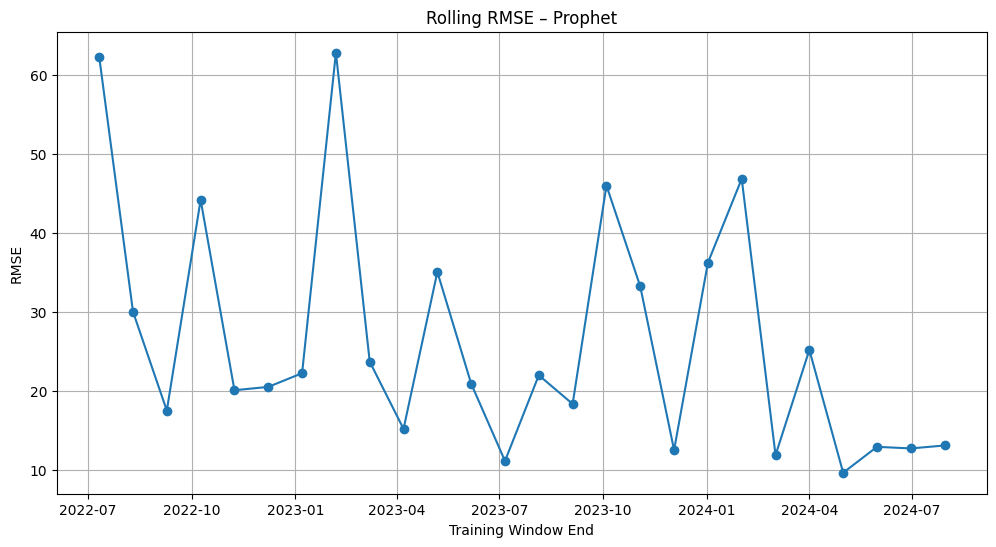

Rolling RMSE:    Train_End       RMSE
0  2022-07-11  62.323039
1  2022-08-10  30.030554
2  2022-09-09  17.516443
3  2022-10-09  44.188641
4  2022-11-08  20.095324
5  2022-12-08  20.515571
6  2023-01-07  22.247917
7  2023-02-06  62.807770
8  2023-03-08  23.704729
9  2023-04-07  15.199816
10 2023-05-07  35.064341
11 2023-06-06  20.921643
12 2023-07-06  11.141472
13 2023-08-05  21.995772
14 2023-09-04  18.356804
15 2023-10-04  46.001139
16 2023-11-03  33.228904
17 2023-12-03  12.521239
18 2024-01-02  36.234321
19 2024-02-01  46.852281
20 2024-03-02  11.874686
21 2024-04-01  25.195883
22 2024-05-01   9.654681
23 2024-05-31  12.930380
24 2024-06-30  12.730422
25 2024-07-30  13.101409


In [36]:
plt.plot(rolling_df['Train_End'], rolling_df['RMSE'], marker='o')
plt.title("Rolling RMSE – Prophet")
plt.xlabel("Training Window End")
plt.ylabel("RMSE")
plt.grid(True)
plt.show()

print(f"Rolling RMSE:{rolling_df}")

| Period     | RMSE  | Likely reason               |
| ---------- | ----- | --------------------------- |
| 2022-07-11 | 62.32 | Early data instability      |
| 2023-02-06 | 62.80 | Post-holiday / regime shift |
| 2022-10-09 | 44.18 | Festival season             |
| 2023-10-04 | 46.00 | Diwali / Q4 effects         |
| 2024-02-01 | 46.85 | New-year volatility         |
